In [2]:
####################### IMPORTING ALL LIBRARIES #############################
# Core
import os
import json
import random
import itertools

# Math & Analysis
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Image Processing
from PIL import Image

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Vision
import torchvision.models as models
import torchvision.transforms as transforms

# Machine Learning
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_distances

# Similarity Search
import faiss

##########################################################################
# Setting working directory
os.chdir("/home/ec2-user/SageMaker/spring-2025-final-project-project-group-4")
print("Current working directory:", os.getcwd())

Current working directory: /home/ec2-user/SageMaker/spring-2025-final-project-project-group-4


## 1. Load Pretrained Model
### Load the pretrained model used in Model 1 to extract feature embeddings.

In [3]:
# === Set device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Define the same model architecture ===
class FeatureModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.base.fc = nn.Linear(self.base.fc.in_features, 4)  # 4 classes

    def forward(self, x):
        return self.base(x)

# === Load model and weights ===
model = FeatureModel().to(device)
model.load_state_dict(torch.load("Parsa/checkpoint/feature_model.pth", map_location=device))
model.eval()

# === Extract embedding layers only ===
feature_extractor = nn.Sequential(*list(model.base.children())[:-1])  # 512-dim output

# === Load transform used during training ===
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## 2. Load Embeddings and FAISS Index
### Load the stored embedding vectors and index for similarity search.

In [4]:
# === Load Embeddings and FAISS Index ===
with open("Parsa/checkpoint/clothing_embeddings.json", "r") as f:
    embedding_dict = json.load(f)

image_paths = list(embedding_dict.keys())
embeddings = np.array([embedding_dict[path] for path in image_paths]).astype("float32")
faiss_index = faiss.read_index("Parsa/checkpoint/clothing_faiss.index")

## 3. Visual Similarity Search - Random
### Retrieve and display top-K visually similar items given a random query.

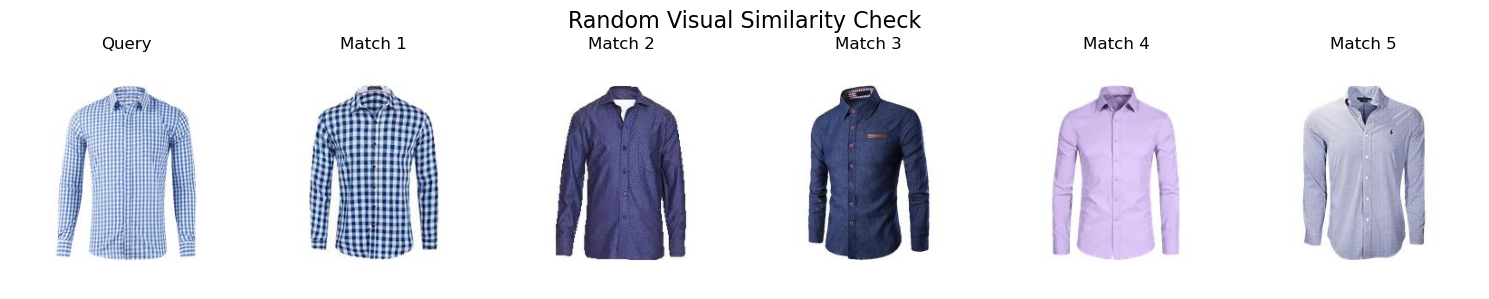

In [5]:
def display_images(image_paths, title="Results"):
    plt.figure(figsize=(15, 3))
    for i, path in enumerate(image_paths):
        if not os.path.exists(path):
            print(f"⚠️ Skipping missing file: {path}")
            continue
        img = Image.open(path).convert("RGB")
        plt.subplot(1, len(image_paths), i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title("Query" if i == 0 else f"Match {i}", fontsize=12)
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def visualize_similar_items(top_k=6):
    idx = random.randint(0, len(image_paths) - 1)
    query_vector = embeddings[idx].reshape(1, -1)
    _, indices = faiss_index.search(query_vector, top_k)
    matched_paths = [image_paths[i] for i in indices[0]]
    display_images(matched_paths, title="Random Visual Similarity Check")

visualize_similar_items()

## 4. Visual Similarity Search - Manual
### Use a specific image as a query to find the top visually similar items.

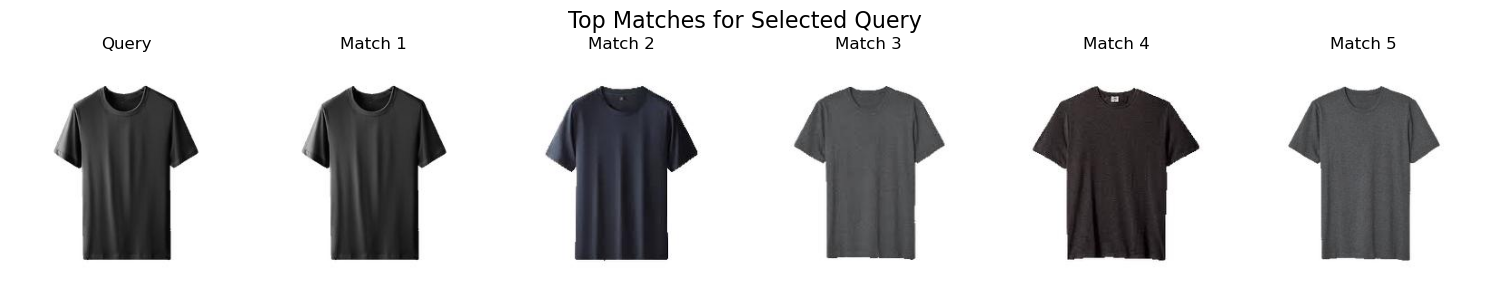

In [6]:
manual_query_path = "Parsa/clothes/t-shirts/15_t-shirts.jpg"
image = Image.open(manual_query_path).convert("RGB")
image_tensor = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    embedding = feature_extractor(image_tensor).squeeze().cpu().numpy()
embedding = np.expand_dims(embedding, axis=0).astype("float32")
_, indices = faiss_index.search(embedding, k=5)
matched_paths = [image_paths[i] for i in indices[0]]
display_images([manual_query_path] + matched_paths, title="Top Matches for Selected Query")


## 5. Embedding Visualization with t-SNE
### Visualize the learned embedding space using dimensionality reduction (t-SNE).

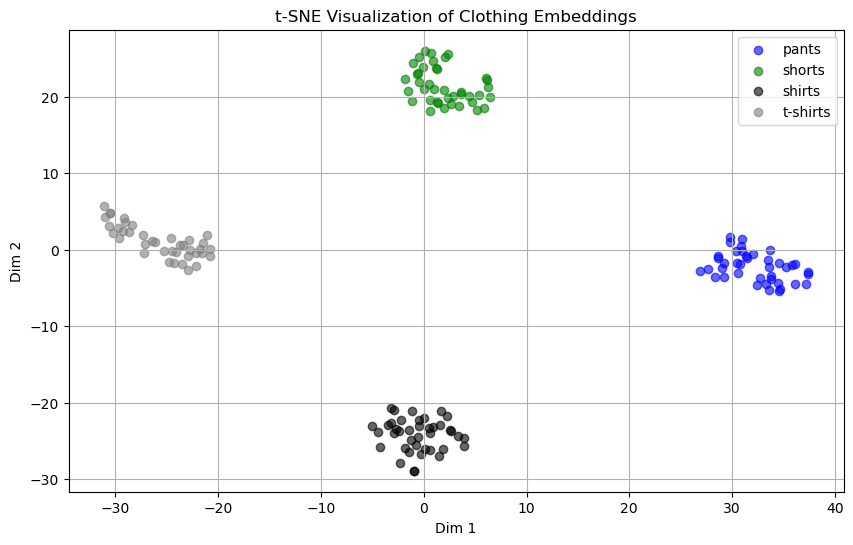

In [7]:
embeddings = []
labels = []
for path, emb in embedding_dict.items():
    embeddings.append(emb)
    if "t-shirts" in path:
        labels.append("t-shirts")
    elif "shirts" in path:
        labels.append("shirts")
    elif "pants" in path:
        labels.append("pants")
    elif "shorts" in path:
        labels.append("shorts")
    else:
        labels.append("unknown")

embeddings = np.array(embeddings)
tsne = TSNE(n_components=2, random_state=42, perplexity=15)
reduced = tsne.fit_transform(embeddings)

colors = {"pants": "blue", "shorts": "green", "shirts": "black", "t-shirts": "grey"}
plt.figure(figsize=(10, 6))
for label in colors:
    idx = [i for i, l in enumerate(labels) if l == label]
    if idx:
        plt.scatter(reduced[idx, 0], reduced[idx, 1], label=label, c=colors[label], alpha=0.6)
plt.legend()
plt.title("t-SNE Visualization of Clothing Embeddings")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()

## 6. Intra-Class and Inter-Class Distances
### Quantify how tightly items are grouped within the same class vs between classes.

In [8]:
class_embeddings = defaultdict(list)
for path, emb in embedding_dict.items():
    if "t-shirts" in path:
        class_embeddings["t-shirts"].append(emb)
    elif "shirts" in path:
        class_embeddings["shirts"].append(emb)
    elif "pants" in path:
        class_embeddings["pants"].append(emb)
    elif "shorts" in path:
        class_embeddings["shorts"].append(emb)

def compute_intra_class_distance(emb_list):
    dist_matrix = cosine_distances(emb_list)
    return np.mean(dist_matrix[np.triu_indices(len(emb_list), k=1)])

print("\n🔍 Intra-class distances:")
for category, emb_list in class_embeddings.items():
    dist = compute_intra_class_distance(np.array(emb_list))
    print(f"{category}: {dist:.4f}")

def compute_inter_class_distance(emb_list1, emb_list2):
    dist_matrix = cosine_distances(emb_list1, emb_list2)
    return np.mean(dist_matrix)

print("\n📏 Inter-class distances:")
categories = list(class_embeddings.keys())
for i in range(len(categories)):
    for j in range(i + 1, len(categories)):
        cat1 = categories[i]
        cat2 = categories[j]
        dist = compute_inter_class_distance(np.array(class_embeddings[cat1]), np.array(class_embeddings[cat2]))
        print(f"{cat1} vs {cat2}: {dist:.4f}")


🔍 Intra-class distances:
shorts: 0.0596
pants: 0.0412
shirts: 0.0496
t-shirts: 0.0335

📏 Inter-class distances:
shorts vs pants: 0.6153
shorts vs shirts: 0.6956
shorts vs t-shirts: 0.6757
pants vs shirts: 0.6631
pants vs t-shirts: 0.7486
shirts vs t-shirts: 0.6522
